# Atlantic and Indopacific basin averaged Merdional Overturning Circulation

Here, we compute the zonally averaged Meridional Overturning Streamfunction in density space in a similar fashion to [this example by Andy Hogg](https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Zonally_Averaged_Global_Meridional_Overturning_Circulation.ipynb)), except we partition the overturning circulation into the Atlantic and IndoPacific Basins. Strong NADW circulation in the Atlantic can sometimes obscure AABW circulation in the IndoPacific in fully zonally averaged plots, something we can minimise by the masking procedure below.

The example uses ACCESS-OM2-01 output (0.1$^\circ$ resolution, RYF 8485 spinup6). Scripts to generate the basin mask will need to be altered before applying the protocol to 0.25$^\circ$ or 1$^\circ$ output.

## 1. Requirements

**The cosima-cookbook**: The `conda/analysis3-19.04` (or later) module on the VDI (or your own up-to-date cookbook installation).

**Model diagnostics**: ``ty_trans_rho``

In [1]:
import xarray as xr
import dask.array
import cosima_cookbook as cc
import numpy as np
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cmocean.cm as cmo
import matplotlib.colors as col
import matplotlib.path as mpath
from matplotlib import rc
rc('text', usetex=True)
rc('xtick', labelsize=25) 
rc('ytick', labelsize=25) 
rc('axes', labelsize=25) 

In [2]:
import warnings
warnings.filterwarnings('ignore')

You should also set up a dask client. The lines below assume that you have set up a scheduler and worker system in your terminal already. Open a terminal tab and run

`dask-scheduler`

and in another terminal tab run

`\dask-worker tcp://localhost:8786 --memory-limit 3e9 --nprocs 6 --nthreads 1 --local-directory /local/$PROJECT/$USER` 

for a basic setup (this is just how I do it, you may have your pet method).

In [3]:
## once you've set up a dask-worker, connect to it, click the dashboard link to check worker status
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 18.00 GB


I've created a database for the RYF8485 spinup (as in `Tutorials/Make_Your_Own_Database.ipynb`), we now initiate a session using this database. 

In [4]:
db = '/g/data/v45/rm2389/databases/ryf_8485_spinup.db' # database path
session = cc.database.create_session(db)
dir_list=['/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_spinup6']
cc.database.build_index(dir_list,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf8485_spinup6


0it [00:00, ?it/s]


0

In [5]:
expt = '01deg_jra55v13_ryf8485_spinup6'

## 2. Create masks for the Atlantic and IndoPacific Basins

Here we want to create two masks; one that masks for the Southern Ocean south of 33S (around the bottom of Africa) and the Atlantic Ocean, and one that masks for the Southern Ocean south of 33S and the Indian plus Pacific Oceans.

A bit of fiddling is a little unavoidable here but the procedure below should be compatible with 0.25$^\circ$ or 1$^\circ$ grid data so you don't have to repeat the whole process.

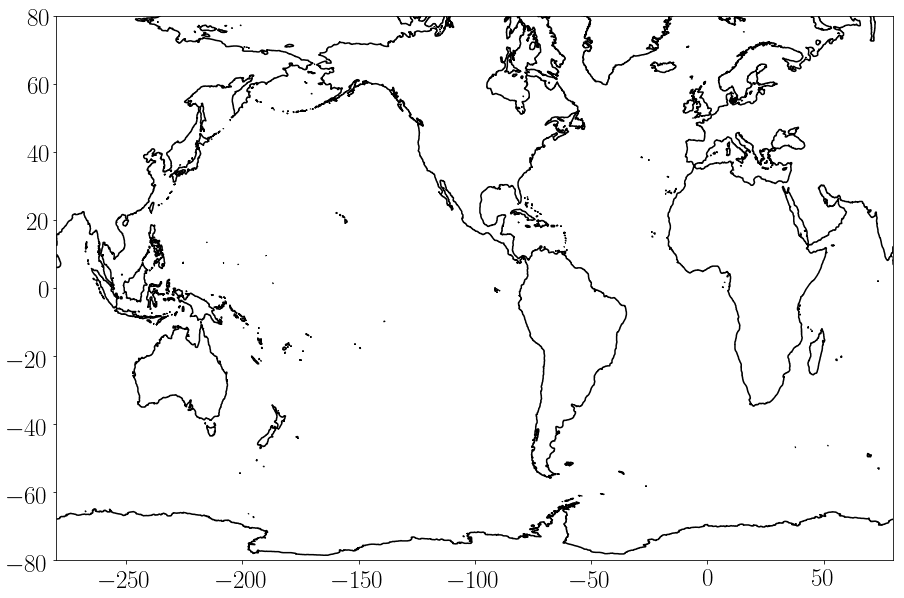

In [6]:
## load grid information and plot a basic map to get your bearings
ht = cc.querying.getvar(expt,'ht',session, n=1) ## needs to be the same coordinates as what you want to mask
land_mask = (ht * 0) + 1
land_mask = land_mask.fillna(0)
fig=plt.figure(2,(15,10))
ax = plt.subplot()
ax.contour(land_mask.xt_ocean, land_mask.yt_ocean,land_mask,[0,1], colors = 'k')
ax.set_xlim([-280,80])
ax.set_ylim([-80,80])
plt.show()

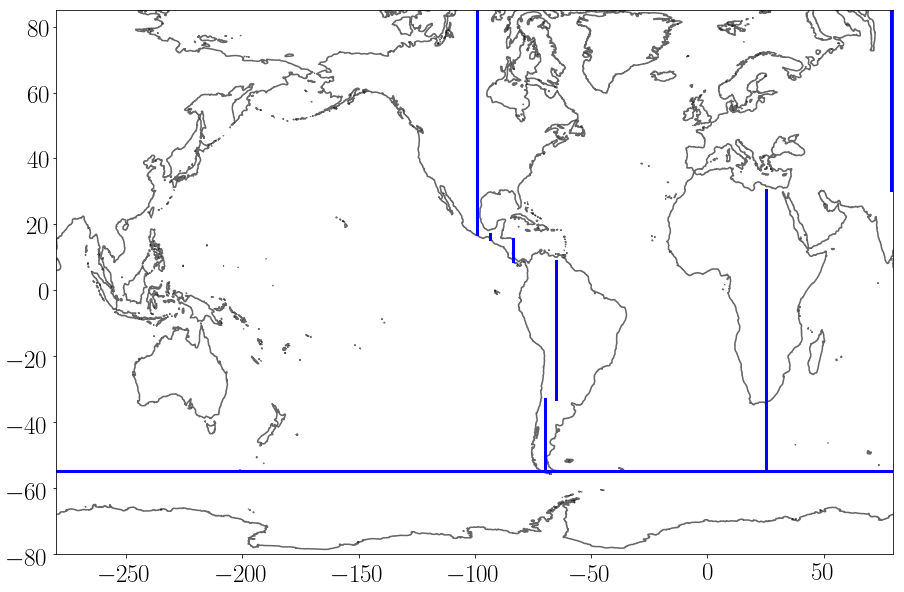

In [7]:
## draw in meridians that lie within land masses separating the two basins, and one for the southern boundary
## not perfect at the panama canal(you can work on that if it really bugs you)
fig=plt.figure(2,(15,10))
ax = plt.subplot()
ax.contour(land_mask.xt_ocean, land_mask.yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
ax.plot([-280,80], [-55,-55], 'b', linewidth = 3)
ax.plot([-65,-65], [-33,9], 'b', linewidth = 3)
ax.plot([-83.7,-83.7], [9,15.5], 'b', linewidth = 3)
ax.plot([-93.3,-93.3], [15.5,17], 'b', linewidth = 3)
ax.plot([-99,-99], [17,85], 'b', linewidth = 3)
ax.plot([25,25], [-55,30.5], 'b', linewidth = 3)
ax.plot([79,79], [30.5,85], 'b', linewidth = 3)
ax.plot([-70,-70], [-55,-33], 'b', linewidth = 3)
ax.set_xlim([-280,80])
ax.set_ylim([-80,85])
plt.show()

In [8]:
## create masks out of the above chunks
south_map = (land_mask.where(land_mask.yt_ocean < -33)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -33).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -33).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

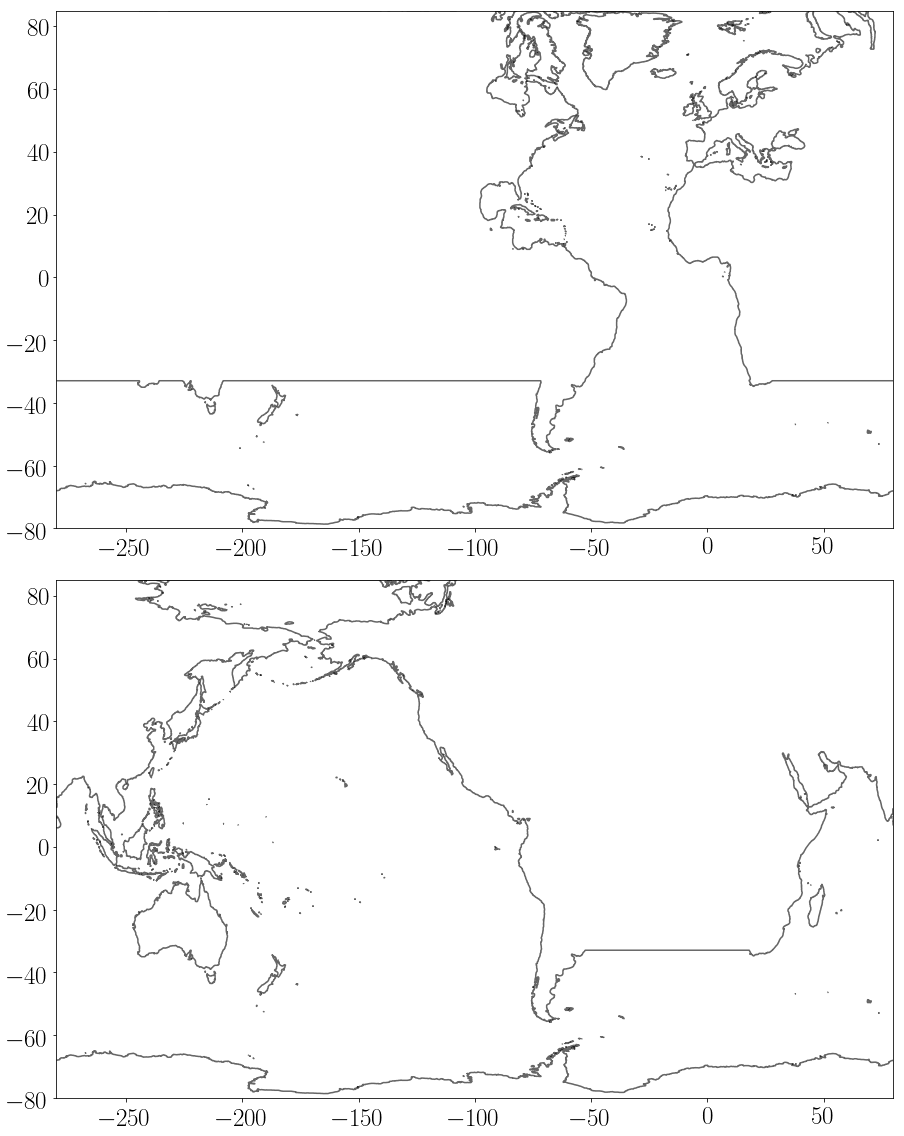

In [9]:
## just to show you what the masks look like...
fig=plt.figure(2,(15,20))
gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.1)
ax, ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])
ax.contour(land_mask.xt_ocean, land_mask.yt_ocean,atlantic_sector_map,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
ax.set_xlim([-280,80])
ax.set_ylim([-80,85])
ax1.contour(land_mask.xt_ocean, land_mask.yt_ocean,indo_sector_map,[0,1], colors = 'k', linewidth = 1, alpha = 0.6)
ax1.set_xlim([-280,80])
ax1.set_ylim([-80,85])
plt.show()

## 3. Mask ty_trans_rho by the basins and compute basin MOC

In [10]:
## the mask above is on a different grid (yt, xt) to psi (yu, xt) so we'll need to alter that
psi = cc.querying.getvar(expt,'ty_trans_rho',session, n=1) ## needs to be the same coordinates as what you want to mask
## done kind of coarsely but we dont need a super perfect mask for this diagnostic
atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})

Using a similar function to that used in the tutorial by Andy Hogg we then compute the basin masked zonally averaged MOC.

In [11]:
def compute_basin_psi_rho(expt,session, nbound, basin_mask, year1=None, year2=None):
    psi = cc.querying.getvar(expt, 'ty_trans_rho',session, n=nbound, time_units = None)
    if year1 != None:
        psi = psi.sel(time = slice(year1, year2))
    psi = psi* 10**(-9); ## convert to Sv
    t1 = psi.time[0].values
    t2 = psi.time[-1].values ## justrecording what dates you take a mean over
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim = 'time').load() # do a weighted average if you're being finicky
    ## you can save the output if you'll be using it again, these computations can take a while with high resolution data
#     ds_psi = xr.Dataset({'psi': psi, 'start_year': year1, 'end_year':year2})
#     ds_psi.to_netcdf(filename)
    return psi, t1, t2

In [12]:
%%time
atlantic_psi, t1, t2 = compute_basin_psi_rho(expt,session, -12, atlantic_sector_mask)

CPU times: user 36.4 s, sys: 974 ms, total: 37.4 s
Wall time: 3min 38s


In [13]:
print(t1, t2) ##2 year mean (longer time periods will take a little while, might be better to save output)

1946-01-16 12:00:00 1947-12-16 12:00:00


In [14]:
%%time
indopacific_psi, t1, t2 = compute_basin_psi_rho(expt,session, -12, indo_sector_mask)

CPU times: user 37.6 s, sys: 1.08 s, total: 38.6 s
Wall time: 4min 2s


In [15]:
print(t1, t2) ##2 year mean (longer time periods will take a little while, might be better to save output)

1946-01-16 12:00:00 1947-12-16 12:00:00


## 4. Plotting

In [16]:
## I prefer the plotting convention of rho-1000
potrho = psi.potrho.values - 1000
atlantic_psi.coords['potrho'] = potrho
indopacific_psi.coords['potrho'] = potrho

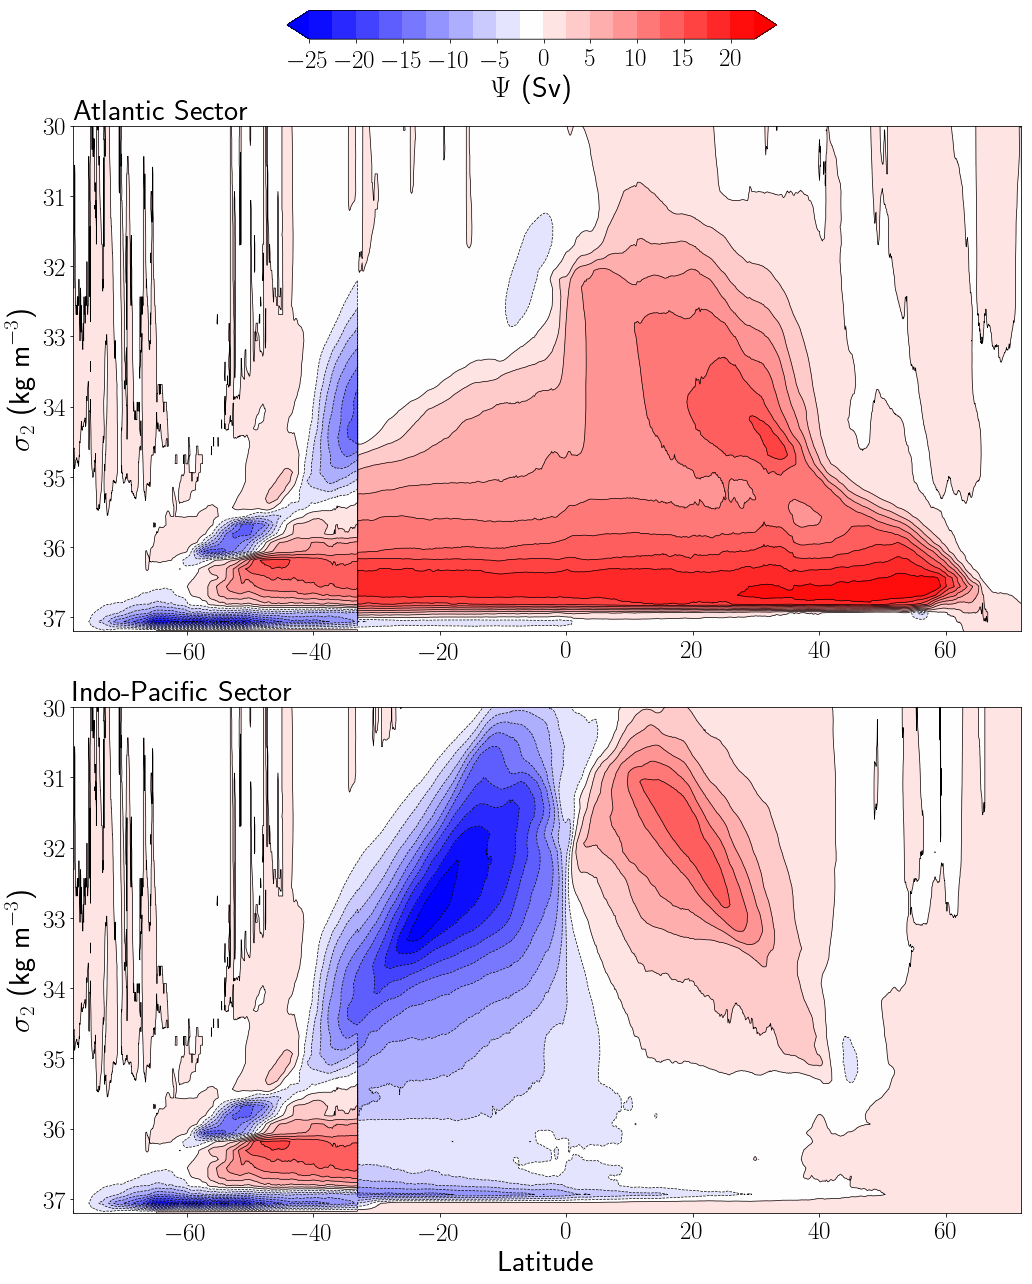

In [17]:
## linear y axis
clev=np.arange(-25,25,2.5)
fig=plt.figure(2,(17,20))
gs = gridspec.GridSpec(2,1) 
ax, ax0 = plt.subplot(gs[0]),plt.subplot(gs[1])
gs.update(hspace = 0.15)

plot = ax.contourf(atlantic_psi.grid_yu_ocean, atlantic_psi.potrho, atlantic_psi, cmap='bwr', levels=clev,extend='both')
ax.contour(atlantic_psi.grid_yu_ocean, atlantic_psi.potrho, atlantic_psi, levels=clev, colors='k', linewidths=0.7)
ax.set_ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 30)
ax.set_xlim([-78,72])
ax.set_ylim([37.2,30])
# plt.setp(ax.get_xaxis(),visible=False)
ax.set_title(r'Atlantic Sector', fontsize = 30,loc = 'left')

ax0.contourf(indopacific_psi.grid_yu_ocean, indopacific_psi.potrho, indopacific_psi, cmap='bwr', levels=clev,extend='both')
ax0.contour(indopacific_psi.grid_yu_ocean, indopacific_psi.potrho, indopacific_psi, levels=clev, colors='k', linewidths=0.7)
ax0.set_ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 30)
ax0.set_xlabel(r'Latitude', fontsize = 30)
ax0.set_xlim([-78,72])
ax0.set_ylim([37.2,30])
ax0.set_title(r'Indo-Pacific Sector', fontsize = 30,loc = 'left')

cax = plt.axes([0.3, 0.94, 0.4, 0.02])
cb=plt.colorbar(plot,cax = cax,orientation='horizontal')
cb.ax.set_xlabel(r'$\Psi$ (Sv)', fontsize = 30)

plt.show()

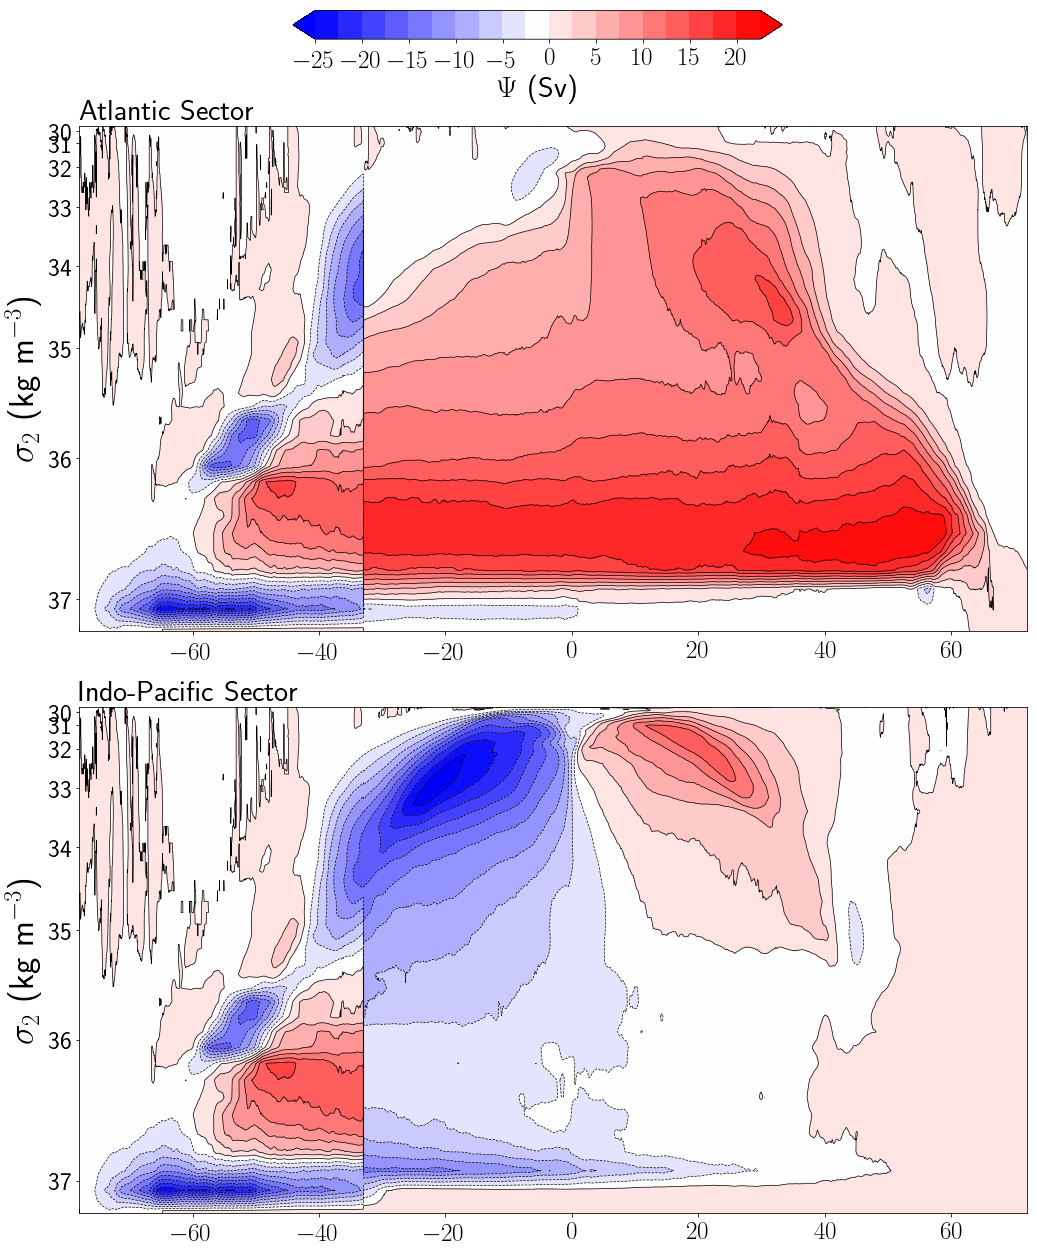

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


In [18]:
## nonlinear (stretched) y axis that accentuates high density classes
clev=np.arange(-25,25,2.5)
fig=plt.figure(2,(17,20))
gs = gridspec.GridSpec(2,1) 
ax, ax0 = plt.subplot(gs[0]),plt.subplot(gs[1])
gs.update(hspace = 0.15)

yticks = np.arange(30,38)
sfac = 3  ## stretch factor (want to highlight dense cells)
plot = ax.contourf(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho-28)**sfac, atlantic_psi, cmap='bwr', levels=clev,extend='both')
ax.contour(atlantic_psi.grid_yu_ocean, (atlantic_psi.potrho-28)**sfac, atlantic_psi, levels=clev, colors='k', linewidths=0.7)
ax.set_yticks((yticks-28)**sfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**sfac, 9.2**sfac])
ax.invert_yaxis()
ax.set_ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 35)
ax.set_xlim([-78,72])
ax.set_title(r'Atlantic Sector', fontsize = 30,loc = 'left')

ax0.contourf(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho-28)**sfac, indopacific_psi, cmap='bwr', levels=clev,extend='both')
ax0.contour(indopacific_psi.grid_yu_ocean, (indopacific_psi.potrho-28)**sfac, indopacific_psi, levels=clev, colors='k', linewidths=0.7)
ax0.set_yticks((yticks-28)**sfac)
ax0.set_yticklabels(yticks)
ax0.set_ylim([0.5**sfac, 9.2**sfac])
ax0.invert_yaxis()
ax0.set_ylabel(r'$\sigma_2$ (kg m$^{-3}$)', fontsize = 35)
ax0.set_xlim([-78,72])
ax0.set_title(r'Indo-Pacific Sector', fontsize = 30,loc = 'left')

cax = plt.axes([0.3, 0.94, 0.4, 0.02])
cb=plt.colorbar(plot,cax = cax,orientation='horizontal')
cb.ax.set_xlabel(r'$\Psi$ (Sv)', fontsize = 30)

plt.show()

These plots compare pretty favourably with the ECCO4 reanalysis overturning cells (see Fig 2 of [Cessi, 2019](https://www.annualreviews.org/doi/full/10.1146/annurev-marine-010318-095241)). I think it adds something to the full zonally averaged picture.